# Detecting artifacts in EEG time series

In [4]:
import os
import pandas as pd
import numpy as np
import mne
import bbtools as bbt

%matplotlib notebook

In [5]:
raw = bbt.read_csv("/Users/Javier/Artificial intelligence/AI6 3rd edition/brain-controlled-game/Mock_lsl_for_testing/Datasets/EEG_blink-jaw-eyesleft-eyesright-30-sec-sequences.csv",
                   ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz'])

Creating RawArray with float64 data, n_channels=16, n_times=32776
    Range : 0 ... 32775 =      0.000 ...   128.027 secs
Ready.


In [76]:
#Drop non-frontal channels
non_frontal_channels = ['C1', 'C2', 'C3', 'C4', 'CP1', 'CP2', 'CP3', 'CP4', 'O1', 'O2', 'Cz', 'Pz']
raw = raw.drop_channels(non_frontal_channels)

<IPython.core.display.Javascript object>


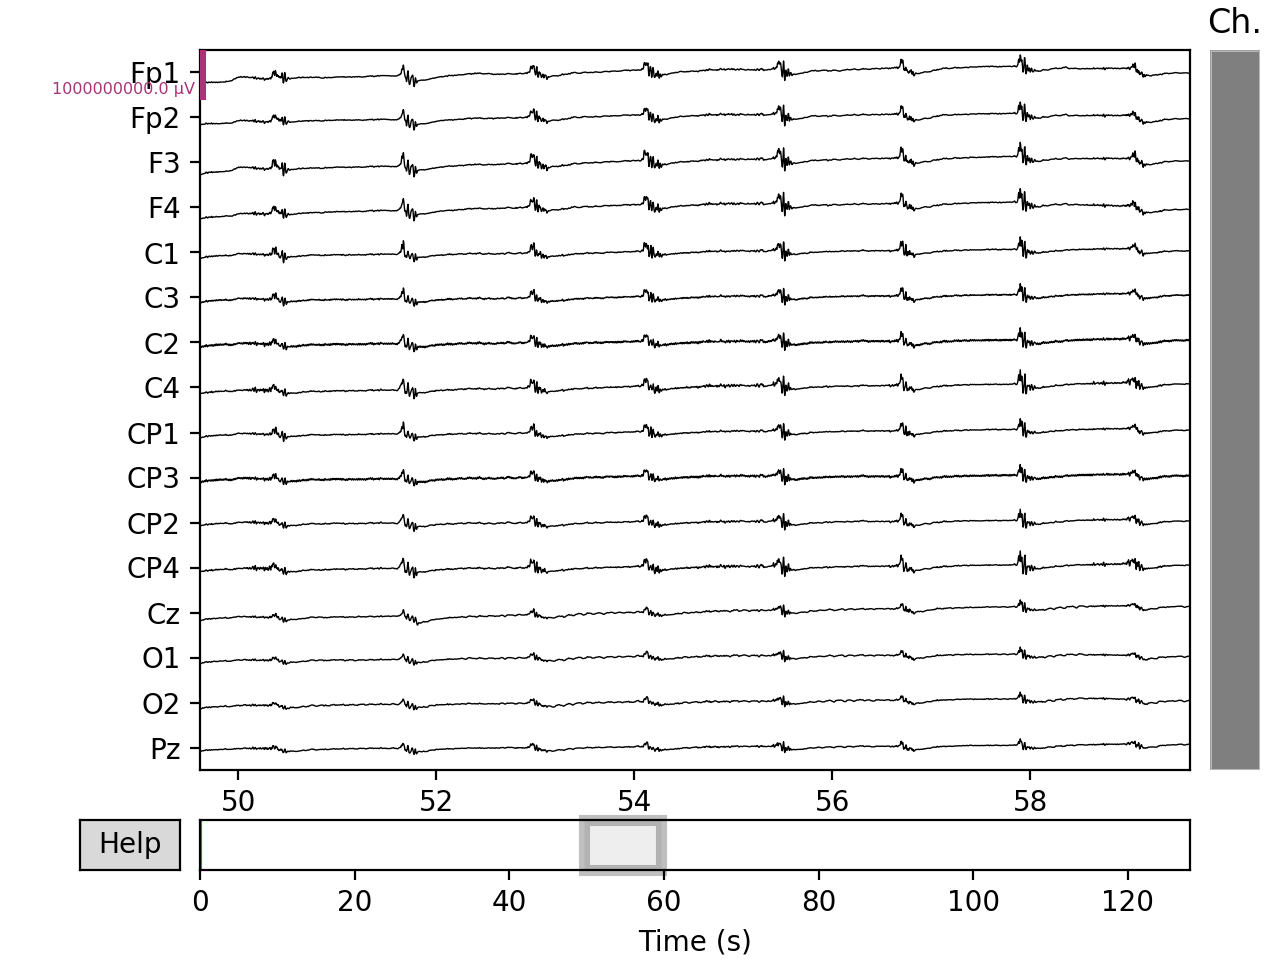

In [6]:
#Here we can look for blinks manually in order to identify when they occur
plot_fig = raw.plot(scalings=0.5e3)
#plot_fig = raw.plot(scalings=0.5e-3)



Now let's identify blinks

In [7]:
#make two datasets using moments with and without blinks
blinks=raw.copy().crop(115, 117).load_data()
no_blinks=raw.copy().crop(96, 100).load_data()

In [8]:
#max (pestañeos fuertes)=410 max (pestañeos normales)=330 min = 170
#now we find max, min and range values for the signal, calculated with numpy, for blinks
average_max_signal=(np.amax(blinks[0][0])+np.amax(blinks[1][0])+np.amax(blinks[2][0])+np.amax(blinks[3][0]))/4
average_min_signal=(np.amin(blinks[0][0])+np.amin(blinks[1][0])+np.amin(blinks[2][0])+np.amin(blinks[3][0]))/4
signal_range = average_max_signal-average_min_signal 

#Vamos a ver como quedan los otros canales para poder comparar
signal_out4=np.amax(blinks[4][0])-np.amin(blinks[4][0])
signal_out6=np.amax(blinks[6][0])-np.amin(blinks[6][0])
signal_out8=np.amax(blinks[8][0])-np.amin(blinks[8][0])
signal_out10=np.amax(blinks[10][0])-np.amin(blinks[10][0])
signal_out_range = (signal_out4 + signal_out6 + signal_out8 + signal_out10)/4
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

print("range_out = " + str(signal_out_range))


max = 3355.230231229425
min = 3125.4858636670497
range = 229.74436756237537
range_out = 128.73423238672513


In [9]:
#now we find max, min and range values for the signal, calculated with numpy, for no_blinks
average_max_signal=(np.amax(no_blinks[0][0])+np.amax(no_blinks[1][0])+np.amax(no_blinks[2][0])+np.amax(no_blinks[3][0]))/4
average_min_signal=(np.amin(no_blinks[0][0])+np.amin(no_blinks[1][0])+np.amin(no_blinks[2][0])+np.amin(no_blinks[3][0]))/4
signal_range = average_max_signal-average_min_signal

#Vamos a ver como quedan los otros canales para poder comparar
signal_out4=np.amax(no_blinks[4][0])-np.amin(no_blinks[4][0])
signal_out6=np.amax(no_blinks[6][0])-np.amin(no_blinks[6][0])
signal_out8=np.amax(no_blinks[8][0])-np.amin(no_blinks[8][0])
signal_out10=np.amax(no_blinks[10][0])-np.amin(no_blinks[10][0])
signal_out_range = (signal_out4 + signal_out6 + signal_out8 + signal_out10)/4
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

print("range_out = " + str(signal_out_range))

max = 3196.076756785325
min = 2831.301373730375
range = 364.77538305495
range_out = 177.35939081537538


In [10]:
#now we find average and peak values, plus others, calculated with numpy, for full dataset
#signal_average=(np.average(raw[0][0])+np.average(raw[1][0])+np.average(raw[2][0])+np.average(raw[3][0]))/4
average_max_signal=(np.amax(raw[0][0])+np.amax(raw[1][0])+np.amax(raw[2][0])+np.amax(raw[3][0]))/4
average_min_signal=(np.amin(raw[0][0])+np.amin(raw[1][0])+np.amin(raw[2][0])+np.amin(raw[3][0]))/4
signal_range = average_max_signal-average_min_signal 

#Vamos a ver como quedan los otros canales para poder comparar
signal_out4=np.amax(raw[4][0])-np.amin(raw[4][0])
signal_out6=np.amax(raw[6][0])-np.amin(raw[6][0])
signal_out8=np.amax(raw[8][0])-np.amin(raw[8][0])
signal_out10=np.amax(raw[10][0])-np.amin(raw[10][0])
signal_out_range = (signal_out4 + signal_out6 + signal_out8 + signal_out10)/4
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

print("range_out = " + str(signal_out_range))

max = 3438.24130087975
min = 1625.1054199753003
range = 1813.1358809044496
range_out = 918.5516008606999


We can see that blinks tend to have a range around 0.00026, while parts with no blinks have values of less than 0.0002, and the overall dataset has an overall range of 0.0088

We are going to establish that a given epoch will have a blink if its signal range is within the limits typical for blinks

In [28]:
#let's test here for specific code fragments and see if it would be a blink
test=raw.copy().crop(50, 55).load_data()
average_max_signal=(np.amax(test[0][0])+np.amax(test[1][0])+np.amax(test[2][0])+np.amax(test[3][0]))/4
average_min_signal=(np.amin(test[0][0])+np.amin(test[1][0])+np.amin(test[2][0])+np.amin(test[3][0]))/4
signal_range = average_max_signal-average_min_signal 
#Vamos a ver como quedan los otros canales para poder comparar
signal_out4=np.amax(test[4][0])-np.amin(test[4][0])
signal_out6=np.amax(test[6][0])-np.amin(test[6][0])
signal_out8=np.amax(test[8][0])-np.amin(test[8][0])
signal_out10=np.amax(test[10][0])-np.amin(test[10][0])
signal_out_range = (signal_out4 + signal_out6 + signal_out8 + signal_out10)/4
print("max = " + str(average_max_signal))
print("min = " + str(average_min_signal))
print("range = " + str(signal_range))

print("range_out = " + str(signal_out_range))

max = 2839.7579230223246
min = 2287.420535365875
range = 552.3373876564497
range_out = 430.92810875707517


In [29]:
# if the signal range is between the values below we will consider this a blink and send a blink signal to the game 
if (signal_range >= 170 and signal_range <= 410 and signal_out_range < signal_range/2):
    print ("blink")
elif (signal_range >= 300 and signal_range <= 600 and signal_out_range > signal_range*2/3):
    print ("bite") 
#podemos asociar bite a que se agache el dinosaurio (habría que tocar el código del juego, podemos preguntar a Javi)

bite
